# Introduction


**What?** Probability calibration for classification

**Reference:** https://github.com/ethen8181/machine-learning/blob/master/model_selection/prob_calibration/prob_calibration.ipynb<br>



# Import modules

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Probability Calibration

Well calibrated classifiers are classifiers for which the output probability can be directly interpreted as a confidence level. The definition of a well calibrated (binary) classifier should classify samples such that among the samples which the model gave a predicted probability value close to 0.8, approximately 80% of them actually belong to the positive class. For example, when looking up the weather forecast, we usually get a precipitation probability. e.g. If the weather forecast says there's a 80% chance of raining, then how trustworthy is this probability? In other words, if we take 100 days of data that were claimed to have a 80% chance of raining, how many rainy days were there? If the number of rainy days were around 80, then that means that particular rain forecast is indeed well calibrated.

As it turns out, a lot of the classifiers/models that we used on a day to day basis might not be calibrated right out of the box, either due to the objective function of the model or simply when working with highly imbalanced datasets, our model's probability estimates can be skewed towards the majority class. Another way to put it is: After training a classifier, the output we get might just be a ranking score instead of well calibrated probability. A ranking score is essentially evaluating how well does the model score positive examples above negative ones, whereas a calibrated probability is evaluating how closely the scores generated by our model resembles an actual probability.

Obtaining a well calibrated probability becomes important when:

- We wish to use the probability threshold to inform some action. e.g. We'll reject the loan approval if the default rate is higher than 50% or we'll defer the judgment to humans if the probability is lower than some threshold.
- If our ranking formula is not solely based on the original model's score. In some cases, we may wish to use the score/probability along with some additional factors for ranking purpose. e.g. In the [advertising cost per click model](https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html), we're going to rank the ads by its expected value (the probability of clicking on the ad multiplied by the ad fee for the click).

## Data Preprocessing

We'll be using the credit card default dataset from UCI, we can download this dataset from [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) as well.

In [2]:
input_path = '../../../DATASETS/UCI_Credit_Card.csv'
df = pd.read_csv(input_path)
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
id_cols = ['ID']
cat_cols = ['EDUCATION', 'SEX', 'MARRIAGE']
num_cols = [
    'LIMIT_BAL', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
label_col = 'default.payment.next.month'

input_cols = num_cols + cat_cols

In [4]:
label_distr = np.round(np.bincount(df[label_col]) / df.shape[0], 3)
print('label distribution: ', label_distr)

label distribution:  [0.779 0.221]


We'll generate a train/validation/test three way split. The validation set created here is mainly used to calibrate our model. As per good practice, we should not be using the same dataset for both the training and calibration process.

In [5]:
test_size = 0.1
val_size = 0.3
random_state = 1234

df_train, df_test = train_test_split(
    df,
    test_size=test_size,
    random_state=random_state,
    stratify=df[label_col])

df_train, df_val = train_test_split(
    df_train,
    test_size=val_size,
    random_state=random_state,
    stratify=df_train[label_col])

print('train shape: ', df_train.shape)
print('validation shape: ', df_val.shape)
print('test shape: ', df_test.shape)

df_train.head()

train shape:  (18900, 25)
validation shape:  (8100, 25)
test shape:  (3000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
9256,9257,20000.0,2,3,1,23,1,2,2,-2,...,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,1
23220,23221,150000.0,2,3,2,35,-1,2,-1,2,...,1143.0,163.0,2036.0,0.0,2264.0,0.0,163.0,2036.0,0.0,0
11074,11075,260000.0,2,2,1,43,2,2,2,2,...,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1583,1584,50000.0,2,1,2,70,2,2,0,0,...,17793.0,18224.0,18612.0,0.0,2200.0,700.0,700.0,674.0,608.0,0
8623,8624,390000.0,2,2,1,45,1,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3971.0,1


## Model Training

We'll train a binary classifier to predict default payment, and evaluate the model using some common evaluation metrics. In our example, we'll only focus on the widely used boosted tree open sourced library xgboost, though the calibration process and technique introduced in later section is applicable for any arbitrary model.

In [6]:
# parameters chosen in an adhoc manner
xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 30
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(df_train[input_cols].values, df_train[label_col].values)

XGBClassifier(max_depth=6, n_estimators=30)

A lot of the helper functions/class are organized as under the `calibration_module`, which can be found under the same folder as this notebook. [link](https://github.com/ethen8181/machine-learning/tree/master/model_selection/prob_calibration)

In [7]:
from calibration_module.utils import compute_binary_score

# evaluate the metrics for training and validation set
estimators = {
    'xgb': xgb
}
df_groups = {
    'train': df_train,
    'val': df_val
}

estimator_metrics = []
for name, estimator in estimators.items():
    for df_name, df_group in df_groups.items():
        y_prob = estimator.predict_proba(df_group[input_cols].values)[:, 1]
        # compute various binary classification metrics
        metric_dict = compute_binary_score(df_group[label_col], y_prob)
        metric_dict['name'] = name + '_' + df_name
        estimator_metrics.append(metric_dict)

df_metrics = pd.DataFrame(estimator_metrics)
df_metrics

,auc,precision,recall,f1,log_loss,brier,name
0,0.8293,0.5667,0.6163,0.5904,0.3958,0.1213,xgb_train
1,0.7872,0.5177,0.5954,0.5539,0.4257,0.1330,xgb_val


## Measuring Calibration

We'll first discuss how do we measure whether a model is well-calibrated or not. The main idea here is to first discretize our model predictions into $M$ interval bins, and calculate the average fraction of positives and predicted probability of each bin. Here, the number of bin is configurable, and samples that have similar predicted score will fall into the same bin.

Let $B_m$ be the set of samples whose predicted probability falls into interval $I_m = \big( \frac{m - 1}{M}, \frac{m}{M}\big]$. The fraction of positives for $B_m$ can be computed by:

\begin{align}
pos(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} y_i
\end{align}

Where $y_i$ is the true class label for sample $i$ (assuming in the binary classification setting 1 denotes a positive class and 0 otherwise). On the other hand, the predicted probability within bin $B_m$ is defined as:

\begin{align}
prob(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p_i}
\end{align}

Where $\hat{p_i}$ is the predicted probability for sample $i$. Given the two terms, fraction of positives and predicted probability within each bin, we can either build a calibration curve to visualize the amount of miscalibration or directly compute a summary statistics.

**Calibration Curve** or also known as a **Reliability Diagram**. For each bin, the mean predicted probability, $prob(B_m)$, is plotted against the fraction of positive cases for that bin, $pos(B_m)$. If the model is well-calibrated, then the points will fall near the diagonal line, and any deviation from that diagonal line in the visualization depicts some level of miscalibration with our model.

**Expected Calibrator Error (ECE)** is one commonly used summary statistic that measures the difference between the expected probability and fraction of positives.

\begin{align}
ECE = \sqrt{ \sum_{m=1}^M \frac{|B_m|}{n} \big(prob(B_m) - pos(B_m)\big)^2 }
\end{align}

Where $n$ is the total number of samples. Here the expected calibration error is measured by the RMSE (Root Meas Squared Error) between $prob(B_m)$ and $pos(B_m)$. If we wish to have a metric that is less sensitive to outliers, we could also switch to MAE (Mean Absolute Error).


We'll now take a look at these concepts in action.

In [8]:
# extract the validation and test true label and predicted probability,
# as we are working with binary classification in this use case, we can
# extract the predicted probability for the positive class
labels_val = df_val[label_col].values
xgb_pred_val = xgb.predict_proba(df_val[input_cols].values)[:, 1]

labels_test = df_test[label_col].values
xgb_pred_test = xgb.predict_proba(df_test[input_cols].values)[:, 1]

We implement a `compute_calibration_summary` that builds on top of scikit-learn's [`calibration_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html). Instead of only plotting the calibration curve, we also return a table that contains summary statistics on the model performance, and calibration error.

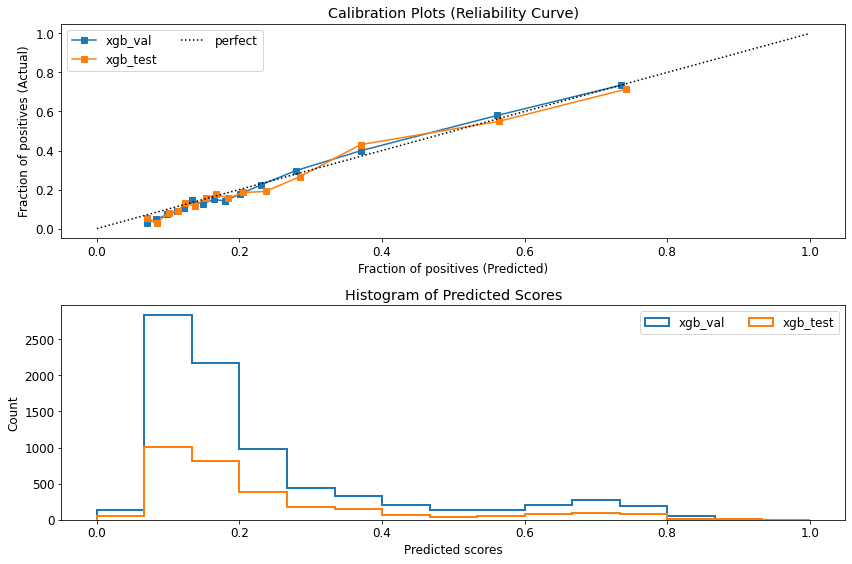

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.7872,0.5177,0.5954,0.5539,0.4257,0.1330,0.0240,xgb_val
1,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb_test


In [9]:
from calibration_module.utils import compute_calibration_summary

# link the label and probability into a dataframe
score_col = 'score'
df_xgb_eval_val = pd.DataFrame({
    label_col: labels_val,
    score_col: xgb_pred_val
})
df_xgb_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: xgb_pred_test
})

# key to the dictionary is for giving the result
# a descriptive name
eval_dict = {
    'xgb_val': df_xgb_eval_val,
    'xgb_test': df_xgb_eval_test
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

n_bins = 15
df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result

Judging from the calibration plot, we can see there are some points that fall above and below the diagonal line.

- Below the diagonal: The model has over-forecast; the probabilities are too large.
- Above the diagonal: The model has under-forecast; the probabilities are too small.

But from the looks of it, it seems like the predicted score is pretty well calibrated as the dots fall closely to the diagonal line.

## Calibration Model

The calibration technique that we'll be introducing here are all rescaling operation that is applied after the predictions have been made by a predictive mode, i.e. this assumes we already have a model, and we would only like to perform some post-processing steps to calibration our original model's prediction. As mentioned in the data preprocessing step, When training/learning the calibration function, we should ensure the data that is used to fit the original model and the one that is used for calibration does not overlap. e.g.

- We can split the data into training / validation set, After our base model is trained on the training
set, the predictions on the validation set are used to fit the calibration model.
- Or do it in a cross validation way, where the data is split into $C$ folds. For each fold, one part is held aside for use as an validation set while the training is performed using the other $C-1$ fold. After repeating the process for all $C$ folds, we can compute final probability by doing an arithmetic mean of the calibrated classifier's predictions.
- Whether we're using train/validation split, or cross validation. It boils down to using the predicted probability as the single input feature, and the hold set's label as the target.
- To evaluate whether we successfully calibrated our model, we can/should check various evaluation metrics. e.g. Our ranking metrics such as AUC should remain somewhat the same, whereas our probability-related metrics such as calibration error should improve.

We'll introduce some notations for discussing the calibration models itself. Assuming a binary classification setting, where given a sample $x_i$ and its corresponding label $y_i$, our original model will produce a predicted probability of the positive class $\hat{p_i}$. Given that most models are not calibrated out of the box, the calibration model's goal is to post processed $\hat{p_i}$ and produce a well calibrated probability $\hat{q_i}$.

Two popular choices are **Platt Scaling** and **Isotonic Regression**.

**Platt Scaling:** Is a parametric approach. At a high level, Platt Scaling amounts to training a logistic regression on of the original classifier's output with respect to the true class labels.

**Isotonic Regression:** A non-parametric approach. With this approach, the idea is to fit a piecewise constant non-decreasing function, where we would merge similar scores into bins such that each bin becomes monotonically increasing. e.g. The first bin may have the range [0, 0.2] and probability 0.15, meaning that any instance with a score between 0 and 0.2 should be assigned a probability estimate of 0.15. More formally,

\begin{align}
&  \underset{\mathbf{\theta, a}}{\text{min}}
&& \sum_{m=1}^M \sum_{i=1}^n \mathbb{1} (a_m \leq \hat{p_i} < a_{m+1}) (\theta_m - y_i)^2 \\ \nonumber
&  \text{subject to}
&& 0 = a_1 \leq a_2 \leq ... \leq a_{M+1} = 1, \theta_1 \leq \theta_2 \leq ... \theta_M
\end{align}

Where $M$ is the number of bins, $a_1, ..., a_{M+1}$ are the interval boundaries that defines each mutually exclusive bins, $B_1, ..., B_M$. $\theta_1, ..., \theta_M$ are the corresponding calibrated score for $\hat{p_i}$ that fall under the bin's boundaries. During the optimization process, the bin boundaries and prediction values are jointly optimized.

In general, Platt Scaling is preferable if the calibration curve has a sigmoid shape and when there is few calibration data. Whereas, Isotonic Regression, being a non-parametric method, is preferable for non-sigmoid calibration curves and in situations where many additional data can be used for calibration. But again, it doesn't hurt to try both approaches on our data and see which one leads to a lower calibration error on the holdout test set.

Apart from Platt Scaling and Isotonic Regression that we'll often come across in online materials, here we'll also introduce two additional methods. Namely, **Histogram Binning** and **Platt Scaling Binning**

**Histogram Binning** is a stricter version of Isotonic Regression, where we would directly define the bin boundaries either by choosing it to be of equal length interval or equal sample size interval. As for the prediction values for each bin, we would set it equal to the $pos(B_m)$, the average number of positive samples in that bin.

**Platt Scaling Binning** is a blend of Platt Scaling and Histogram Binning. We first fit a Platt Scaling function, $f$, then just like Histogram Binning, we would bin the input samples. The main difference here is that we would bin the samples with the output from Platt Scaling instead of the original predicted probability. And for each bin, the calibrated prediction is the average of the scaling function, $f$, instead of the average number of positive samples. The motivation behind this method is the output from our scaling function lies within a narrower range than the original label values, hence it should introduce a lower calibration error.

One important thing to note is (not commonly mentioned) while applying Platt Scaling related calibration method is that logistic regression assumes a linear relationship between the input and log odds class probability output. Hence in theory, it should be beneficial to first transform the class probability $p$ into a log odds scale, $z$ before passing it to Platt Scaling.

\begin{align}
z = \log \left({p\over 1-p}\right)
\end{align}

In [10]:
from sklearn.calibration import IsotonicRegression
from calibration_module.calibrator import (
    HistogramCalibrator,
    PlattCalibrator,
    PlattHistogramCalibrator
)

In [11]:
isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=xgb_pred_val.min(),
                              y_max=xgb_pred_val.max())
isotonic.fit(xgb_pred_val, labels_val)
isotonic_probs = isotonic.predict(xgb_pred_test)
isotonic_probs

array([0.22972973, 0.14263076, 0.05276734, ..., 0.13581395, 0.11445783,
       0.36842105], dtype=float32)

In [12]:
histogram = HistogramCalibrator(n_bins=n_bins)
histogram.fit(xgb_pred_val, labels_val)
histogram_probs = histogram.predict(xgb_pred_test)
histogram_probs

array([0.22407407, 0.14074074, 0.02962963, ..., 0.12592593, 0.10555556,
       0.39814815])

In [13]:
platt = PlattCalibrator(log_odds=True)
platt.fit(xgb_pred_val, labels_val)
platt_probs = platt.predict(xgb_pred_test)
platt_probs

array([0.2116992 , 0.16321564, 0.05074317, ..., 0.12652918, 0.10286036,
       0.35680279])

In [14]:
platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=True)
platt_histogram.fit(xgb_pred_val, labels_val)
platt_histogram_probs = platt_histogram.predict(xgb_pred_test)
platt_histogram_probs

array([0.21283885, 0.15907912, 0.05334451, ..., 0.12737967, 0.10104891,
       0.3687527 ])

## Calibration Model Evaluation

In this section, we compare the calibration error of various calibration models.

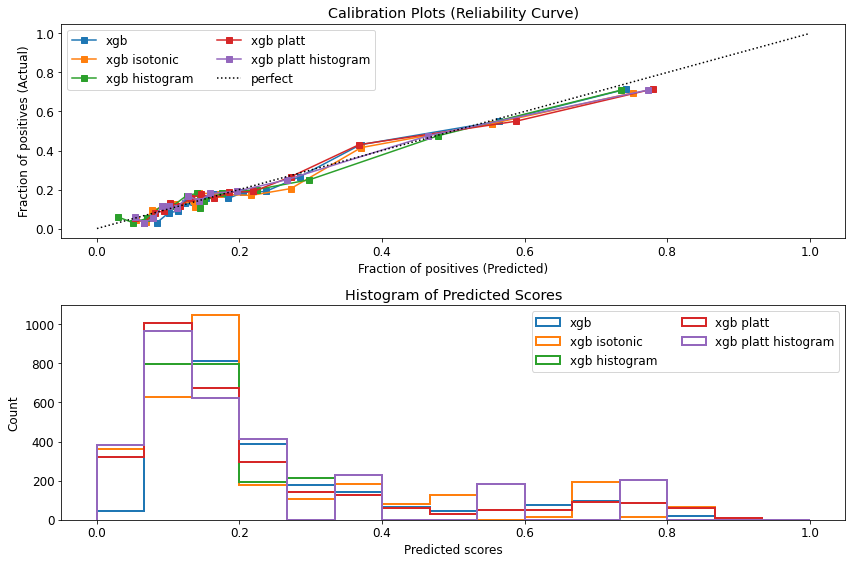

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
4,0.7706,0.5525,0.5151,0.5331,0.4376,0.1379,0.0243,xgb platt histogram
2,0.7665,0.5525,0.5151,0.5331,0.4379,0.1379,0.0258,xgb histogram
0,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb
3,0.7739,0.5423,0.5602,0.5511,0.4349,0.1369,0.0304,xgb platt
1,0.7736,0.5423,0.5602,0.5511,0.4342,0.1367,0.0369,xgb isotonic


In [15]:
score_col = 'score'
df_xgb_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: xgb_pred_test
})
df_xgb_isotonic_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: isotonic_probs + 1e-3
})
df_xgb_platt_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_probs
})
df_xgb_platt_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_histogram_probs
})
df_xgb_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: histogram_probs
})


eval_dict = {
    'xgb': df_xgb_eval_test,
    'xgb isotonic': df_xgb_isotonic_eval_test,
    'xgb histogram': df_xgb_histogram_eval_test,
    'xgb platt': df_xgb_platt_eval_test,
    'xgb platt histogram': df_xgb_platt_histogram_eval_test
}

df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result.sort_values('calibration_error')

We also test out the calibration error by Platt Scaling related methods without the log odds transformation. It turns out, in this example, missing the log odds transformation step undermines the performance by a significant amount.

In [16]:
platt = PlattCalibrator(log_odds=False)
platt.fit(xgb_pred_val, labels_val)
platt_probs = platt.predict(xgb_pred_test)
platt_probs

array([0.1854087 , 0.14956946, 0.08383791, ..., 0.12562479, 0.11153563,
       0.3220031 ])

In [17]:
platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=False)
platt_histogram.fit(xgb_pred_val, labels_val)
platt_histogram_probs = platt_histogram.predict(xgb_pred_test)
platt_histogram_probs

array([0.18644158, 0.14676159, 0.08514048, ..., 0.12617081, 0.11050533,
       0.33625734])

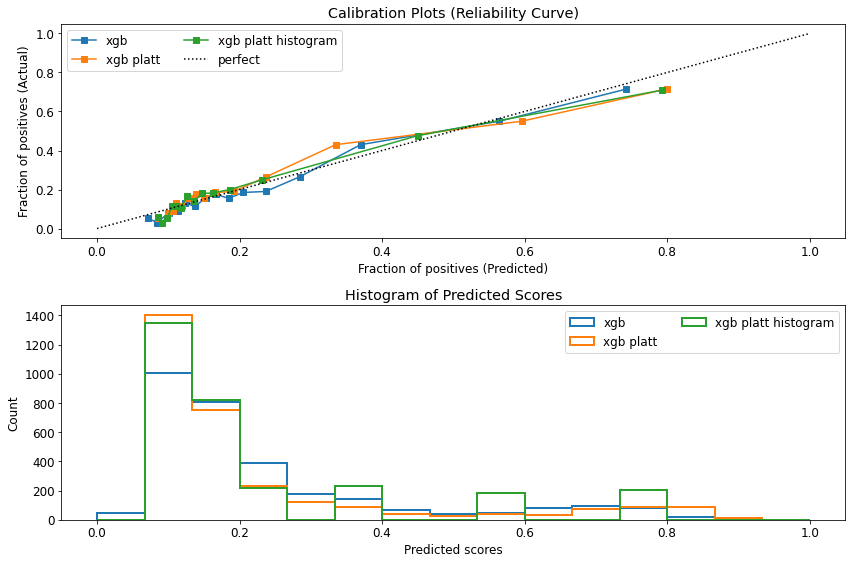

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb
2,0.7706,0.5525,0.5151,0.5331,0.4408,0.1388,0.0363,xgb platt histogram
1,0.7739,0.5423,0.5602,0.5511,0.4385,0.1379,0.0425,xgb platt


In [18]:
df_xgb_platt_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_probs
})
df_xgb_platt_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_histogram_probs
})

eval_dict = {
    'xgb': df_xgb_eval_test,
    'xgb platt': df_xgb_platt_eval_test,
    'xgb platt histogram': df_xgb_platt_histogram_eval_test
}

df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result.sort_values('calibration_error')

## Final Notes

Although our primary focus was on calibrating binary classification models, we can extend the concepts and notations to multi-class setting by treating the problem as $K$ one versus all problems, where $K$ is the number of distinct classes. For $k = 1, ..., K$, we would create a binary classification where the label is $\mathbb{1}(y_i = k)$, giving us $K$ calibration model, one for each class.

Other than the techniques introduced here, there are many other methods that can be used to calibrate our model. e.g. for ease of production, some work resort to using a piecewise linear function:

\begin{align}
\hat{q_i}=
\begin{cases}
\hat{p_i} & \hat{p_i} < t_c \\
t_c \cdot \big( 1 + log( \frac{\hat{p_i}}{t_c} ) \big) & \hat{p_i} \geq t_c
\end{cases}
\end{align}

In this case, the calibration function is saying for any predicted probability higher than a user-defined calibration threshold $t_c$, we will scale the prediction using the function specified above. The piecewise linear function can be of any arbitrary function, and unlike the other estimators that we can directly plug and play, this requires us to have a much better understanding of our data's distribution.

Given all the rage with deep learning models lately, there are even ones that are tailored for them. Calibration also becomes an important topic there, as modern neural networks often times optimizes for negative log likelihood. Upon being able to correctly classify the majority of the training samples, that measure can be further minimized by increasing the probability of its prediction, which will ultimately result in over/under confident predicted score.

One caveat to note about measuring calibration error is that the number of bins do matter, play with the parameter and we might find surprising results. As we are measuring the calibration error of a continuous output (probability output from the model) by grouping samples into finite set of bins, the measure that we've obtained will only be an approximation of the true calibration error. The intuition behind this is that averaging a continuous number within a bin allows errors at different regions of a bin to cancel out with each other.

# Reference

- [Blog: Probability calibration](https://jmetzen.github.io/2015-04-14/calibration.html)
- [Blog: A Guide to Calibration Plots in Python](https://changhsinlee.com/python-calibration-plot/)
- [Blog: How and When to Use a Calibrated Classification Model with scikit-learn](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)
- [Youtube - Model Calibration - is your model ready for the real world?](https://www.youtube.com/watch?v=FkfDlOnQVvQ)
- [Sklearn Documentation: Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)
- [Sklearn Documentation: Probability calibration curves](https://scikit-learn.org/stable/auto_examples/calibration/compute_calibration_summary.html)
- [Paper: A. Niculescu-Mizil, R. Caruana (2012) - Obtaining Calibrated Probabilities from Boosting](https://arxiv.org/abs/1207.1403)
- [Paper: T. Leathart, E. Frank, G. Holmes, B. Pfahringer (2017) - Probability Calibration Trees](https://arxiv.org/abs/1808.00111)
- [Paper: C. Guo, G.Pleiss, Y. Sun, K. Weinberger (2017) - On Calibration of Modern Neural Networks](https://arxiv.org/abs/1706.04599)
- [Paper: A. Kumar, P. Liang, T. Ma (2020) - Verified Uncertainty Calibration](https://arxiv.org/abs/1909.10155)